## **Layer.ai Air Quality Prediction Challenge**


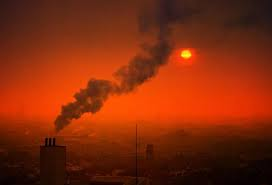

## **Install Layer**

In [5]:
%%capture
!pip install -U layer
!pip install catboost

# **UTILS**

In [6]:
import layer
from layer.decorators import dataset,model, pip_requirements

In [7]:
import sklearn
import datetime
import numpy as np
import pandas as pd 
import catboost
from catboost import CatBoostRegressor

from sklearn.cluster import KMeans
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from google.colab import files

import warnings
warnings.simplefilter('ignore')

In [8]:
print(f"Numpy version=={np.__version__}")
print(f"Pandas version=={pd.__version__}")
print(f"catboost version=={catboost.__version__}")
print(f"sklearn version=={sklearn.__version__}")

Numpy version==1.21.6
Pandas version==1.3.5
catboost version==1.1
sklearn version==1.0.2


In [9]:
from sklearn.model_selection import KFold, StratifiedKFold

In [10]:
class PARAM:
  
  SEED = 42

  n_splits = 10

  params_xgb = {
            'gpu_id': 0, 
            #'n_gpus': 2, 
            'objective': 'reg:squarederror', 
            'eval_metric': 'rmse', 
            'booster': 'gbtree', 
            'n_estimators': 6000, 
            'tree_method': 'gpu_hist', 
            'grow_policy': 'lossguide', 
            'max_depth': 8, 
           'learning_rate': 0.01, 
            'max_bin': 90, #
            'max_leaves': 90, #
            'reg_alpha': 8, 
            'reg_lambda': 20, 
            'subsample': 0.8}
        
folds = KFold(n_splits= PARAM.n_splits, random_state= PARAM.SEED, shuffle = True)

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# **Login to layer**

In [11]:
layer.login()

Please open the following link in your web browser. Once logged in, copy the code and paste it here.
https://app.layer.ai/oauth/authorize?response_type=code&code_challenge=YY3ujvISTDNb-5_WNnHgVHUdGKUSm9pzsbGK5bsDmPk&code_challenge_method=S256&client_id=0STDdcnpK48P8A429EAAn93WNuLmViLR&redirect_uri=https://app.layer.ai/oauth/code&scope=offline_access&audience=https://app.layer.ai
Code: NAG8vdx6KVMAFFcOrO-xnR-zmZSy1sYw_7YOqRwHNbNTN
Successfully logged into https://app.layer.ai


# **Create a Layer project**

In [12]:
layer.init("Air_Quality_Hackathon")

Your Layer project is here: https://app.layer.ai/sodiq_damilola/Air_Quality_Hackathon

# **Fetch the datasets as Pandas DataFrames**

In [13]:
sample_submission = layer.get_dataset("zindi/air-quality/datasets/sample_submission").to_pandas()
test_df = layer.get_dataset("zindi/air-quality/datasets/test").to_pandas()
train_df = layer.get_dataset("zindi/air-quality/datasets/train").to_pandas()

Output()

Output()

Output()

In [14]:
df = pd.concat([train_df.drop("pm2_5", axis = 1), test_df]).reset_index(drop = True)

In [15]:
dropCol = (df.isnull().sum()/len(df))[(df.isnull().sum()/len(df)).gt(0.65)].index.to_list()

In [16]:
train_df = train_df.drop(dropCol, axis = 1).reset_index(drop = True)
test_df = test_df.drop(dropCol, axis = 1).reset_index(drop = True)

# **Data Preprocessing**

In [17]:
class ProcessData:
  
  def process(self,train,test) :

    ID_COL, TARGET_COL = 'ID', 'pm2_5'
    train['date'] = pd.to_datetime(train['date'], format='%Y-%m-%d')
    test['date'] = pd.to_datetime(test['date'], format='%Y-%m-%d')

    train["train"] = 1
    test["train"] = 0

    df = pd.concat([train, test]).reset_index(drop=True)
    df = df.sort_values('date').reset_index(drop=True)

    df.fillna(df.groupby(['device'], as_index=False).mean(), inplace=True)
    df.fillna(df.mean(), inplace=True)

    engFeature = [x for x in df.columns if "angle" not in x if x not in  ["date", "ID", "device", "site_latitude", "site_longitude","pm2_5", "train"]]
    engFeature = [x for x in engFeature if "height" not in x if "depth" not in x if "altitude" not in x]
   
    features = [c for c in df.columns if c not in ['ID', 'date', 'pm2_5']]
    df['device_freq'] = df['device'].map(df['device'].value_counts())

    #########################################################################################################################################

    for i in range(1, 10):
      df[f'target_previous_{i}'] = df[TARGET_COL].shift(i)
      df[f'target_next_{i}'] = df[TARGET_COL].shift(-i)

    for i in range(1, 5):
      df[f'target_next_exp_{i}'] = df[TARGET_COL].shift(i).expanding().mean()
      df[f'target_prev_exp_{i}'] = df[TARGET_COL].shift(-i).expanding().mean()

    for i in range(125, 135):
      df[f'target_previous_{i}'] = df[TARGET_COL].shift(i)
      df[f'target_next_{i}'] = df[TARGET_COL].shift(-i)

    for i in range(125, 135):
      df[f'target_next_exp_{i}'] = df[TARGET_COL].shift(i).expanding().mean()
      df[f'target_prev_exp_{i}'] = df[TARGET_COL].shift(-i).expanding().mean()

    ##############################################################################################################################################

    dropColumns = []
    for day in range(1, 5):
      import math
      colName = 'date' + str(day+1)
      df[colName] = df['date']  + datetime.timedelta(days=day)
      dropColumns.append(colName)

      for col in ['dayofweek', 'weekofyear', 'days_in_month', 'dayofyear']:
        df[colName +"_" + col] = getattr(df['date'].dt, col)
        dropColumns.append(colName + "_" +  col)
        dropColumns.append(colName + "_" + col + "_norm")
        df[colName + "_" + col + "_norm"] = 2 * math.pi * df[colName +"_" + col] / df[colName +"_" + col].max()
        df[colName + "_" + col + "_sin"] = np.sin(df[colName + "_" + col + "_norm"])
        df[colName + "_" + col + "_cos"] = np.cos(df[colName + "_" + col + "_norm"])

    df = df.drop(dropColumns, axis = 1)
    ##############################################################################################################################################
    # ----------------------------------------------------------------------------------------------
    # ROLLING AGGREGATE FEATURES BASED ON DEVICE
    # ----------------------------------------------------------------------------------------------
    for roll in [3, 5, 7, 10, 50, 100]:
      tempdfMean = df.rolling(roll).mean()[engFeature]
      tempdfVar = df.rolling(roll).var()[engFeature]
      for col in engFeature:
        df[f"{col}_rolling_mean_{roll}"] = tempdfMean[col].values
        df[f"{col}_rolling_var_{roll}"] = tempdfVar[col].values

    for i in range(1, 15):
      tmp = df[engFeature].shift(i)
      tmp_diff_prev = df[engFeature] - tmp
      tmp.columns = [c + f'_prev_{i}' for c in tmp.columns]
      tmp_diff_prev.columns = [c + f'_prev_diff_{i}' for c in tmp_diff_prev.columns]
      df = pd.concat([df, tmp, tmp_diff_prev], axis=1)
      
      tmp = df[engFeature].shift(-i)
      tmp_diff_next = df[engFeature] - tmp
      tmp.columns = [c + f'_next_{i}' for c in tmp.columns]
      tmp_diff_next.columns = [c + f'_next_diff_{i}' for c in tmp_diff_next.columns]
      df = pd.concat([df, tmp, tmp_diff_next], axis=1)

    for i in range(1, 5):
      tmp = df[engFeature].shift(i).expanding().mean()
      tmp_diff_prev = df[engFeature] - tmp
      tmp.columns = [c + f'_prev_exp_{i}' for c in tmp.columns]
      tmp_diff_prev.columns = [c + f'_prev_exp_diff_{i}' for c in tmp_diff_prev.columns]
      df = pd.concat([df, tmp, tmp_diff_prev], axis=1)
      
      tmp = df[engFeature].shift(-i).expanding().mean()
      tmp.columns = [c + f'_next_exp_{i}' for c in tmp.columns]
      tmp_diff_next.columns = [c + f'_next_exp_diff_{i}' for c in tmp_diff_next.columns]
      df = pd.concat([df, tmp, tmp_diff_next], axis=1)

    drop_columns = (df.isnull().sum()[(df.isnull().sum()/len(df)) > 0.9]/len(df)).index
    good_col = [x for x in df.columns if x not in drop_columns]
    df = df[good_col]

    #####################################################################################################

    timeFeatures = ['day', 'month', 'week', 'dayofweek']
    for attr in timeFeatures:
          df[attr] = getattr(df['date'].dt, attr)
    df['is_weekend'] = (df['dayofweek'] >= 5)*1
    df['quarter'] = df['day']%15
    df['which_quarter'] = df['day']//15

    for timeFeat in ['day', 'month', 'week', 'dayofweek','quarter', 'device']:
      tempdfMean = df.groupby(timeFeat).mean()[engFeature].to_dict()
      tempdfMedian = df.groupby(timeFeat).median()[engFeature].to_dict()
      tempdfStd = df.groupby(timeFeat).std()[engFeature].to_dict()
      tempdfVar = df.groupby(timeFeat).var()[engFeature].to_dict()
      for col in engFeature:
        df[f"{col}_by_{timeFeat}_mean"] = df[timeFeat].map(tempdfMean[col])
        df[f"{col}-{timeFeat}_mean"] = df[col] - df[f"{col}_by_{timeFeat}_mean"]
        df[f"{col}/{timeFeat}_mean"] = df[col] / df[f"{col}_by_{timeFeat}_mean"]

        df[f"{col}_by_{timeFeat}_median"] = df[timeFeat].map(tempdfMedian[col])
        df[f"{col}-{timeFeat}_median"] = df[col] - df[f"{col}_by_{timeFeat}_median"]
        df[f"{col}/{timeFeat}_median"] = df[col] / df[f"{col}_by_{timeFeat}_median"]

        df[f"{col}_by_{timeFeat}_std"] = df[timeFeat].map(tempdfStd[col])
        df[f"{col}-{timeFeat}_std"] = df[col] - df[f"{col}_by_{timeFeat}_std"]
        df[f"{col}/{timeFeat}_std"] = df[col] / df[f"{col}_by_{timeFeat}_std"]

        df[f"{col}_by_{timeFeat}_var"] = df[timeFeat].map(tempdfVar[col])
        df[f"{col}-{timeFeat}_var"] = df[col] - df[f"{col}_by_{timeFeat}_var"]
        df[f"{col}/{timeFeat}_var"] = df[col] / df[f"{col}_by_{timeFeat}_var"]
    #########################################################################################################################################
    for col1 in engFeature:
      for col2 in engFeature:
        if col1 != col2:
          df[f"{col1}/{col2}"] = df[col1]/df[col2]

    ################################################################################################################################
    df.fillna(df.groupby(['device'], as_index=False).mean(), inplace=True)
    df.fillna(df.mean(), inplace=True)
    # ----------------------------------------------------------------------------------------------
    # ANGLE FEATURES
    # ----------------------------------------------------------------------------------------------
    angleFeat = [x for x in df.columns if "angle" in x]
    df[angleFeat] = df[angleFeat].apply(lambda x : np.radians(x))
    df[[f"{x}_sin" for x in angleFeat]] = df[angleFeat].apply(lambda x : np.sin(x))
    df[[f"{x}_cos" for x in angleFeat]] = df[angleFeat].apply(lambda x : np.cos(x))

    ################################################################################################################################
    for cluster in [10,15,25,35]:
      kmeans = KMeans(n_clusters=cluster)
      kmeans.fit(df[engFeature])
      df[f"Cluster_{cluster}"] = kmeans.predict(df[engFeature])

    for clusterFeat in ["Cluster_10", "Cluster_15", "Cluster_25"]:
      tempdfMean = df.groupby(clusterFeat).mean()[engFeature].to_dict()
      tempdfVar = df.groupby(clusterFeat).var()[engFeature].to_dict()
      for col in engFeature:
        df[f"{col}_by_{clusterFeat}_mean"] = df[clusterFeat].map(tempdfMean[col])
        df[f"{col}_by_{clusterFeat}_var"] = df[clusterFeat].map(tempdfVar[col])
    ################################################################################################################################

    # Get our New Train,Test
    features = [x for x in df.columns if x not in ["ID", "date", "device","pm2_5","train"]]
    train = df[df["train"].eq(1)].drop(["train"], axis = 1).reset_index(drop=True)
    test = df[df["train"].eq(0)].drop(["train"], axis = 1).reset_index(drop=True)
    target = train["pm2_5"]
    test_ID = test["ID"]

    return train[features], test[features], test_ID, target

In [18]:
processor = ProcessData()
train_data, test_data, testID, target= processor.process(train_df , test_df)

In [19]:
train_data.head()

,site_latitude,site_longitude,humidity,temp_mean,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,...,Ozone_cloud_fraction_by_Cluster_25_mean,Ozone_cloud_fraction_by_Cluster_25_var,Cloud_cloud_fraction_by_Cluster_25_mean,Cloud_cloud_fraction_by_Cluster_25_var,Cloud_cloud_top_pressure_by_Cluster_25_mean,Cloud_cloud_top_pressure_by_Cluster_25_var,Cloud_cloud_base_pressure_by_Cluster_25_mean,Cloud_cloud_base_pressure_by_Cluster_25_var,Cloud_surface_albedo_by_Cluster_25_mean,Cloud_surface_albedo_by_Cluster_25_var
0,0.059604,32.46032,0.846583,22.641667,-0.000251,0.527936,-0.000133,0.116888,-1.716240,0.916533,...,0.717963,0.100522,0.713587,0.105528,25685.388565,6.393150e+05,29684.816648,8.684089e+05,0.268219,0.002570
1,0.059604,32.46032,0.783833,24.325000,-0.000132,0.562716,-0.000074,0.023798,-1.757054,0.464903,...,0.258360,0.014138,0.257582,0.012245,80435.874587,2.973320e+06,86689.633408,2.448557e+06,0.263396,0.001715
2,0.059604,32.46032,0.741972,25.725000,-0.000169,0.550671,-0.000093,0.030852,1.334801,0.204861,...,0.179792,0.006565,0.175319,0.005184,87111.317729,1.456092e+06,87804.886494,3.541714e+04,0.278746,0.001397
3,0.059604,32.46032,0.748049,24.607986,-0.000286,0.669683,-0.000192,0.000000,1.285022,0.763453,...,0.401802,0.104967,0.555202,0.027273,49822.814256,1.987413e+05,56065.123332,1.895734e+05,0.267250,0.000793
4,0.059604,32.46032,0.735576,24.857639,-0.000120,0.656247,-0.000079,0.010367,1.250467,1.087169,...,0.179792,0.006565,0.175319,0.005184,87111.317729,1.456092e+06,87804.886494,3.541714e+04,0.278746,0.001397


In [20]:
test_data.head()

,site_latitude,site_longitude,humidity,temp_mean,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,...,Ozone_cloud_fraction_by_Cluster_25_mean,Ozone_cloud_fraction_by_Cluster_25_var,Cloud_cloud_fraction_by_Cluster_25_mean,Cloud_cloud_fraction_by_Cluster_25_var,Cloud_cloud_top_pressure_by_Cluster_25_mean,Cloud_cloud_top_pressure_by_Cluster_25_var,Cloud_cloud_base_pressure_by_Cluster_25_mean,Cloud_cloud_base_pressure_by_Cluster_25_var,Cloud_surface_albedo_by_Cluster_25_mean,Cloud_surface_albedo_by_Cluster_25_var
0,0.289040,32.589580,0.792427,23.349306,0.000149,0.874902,0.000129,0.237890,1.315588,0.431532,...,0.450067,0.072178,0.449008,0.072443,64809.523043,864090.898276,72907.912376,1.258519e+06,0.275098,0.002613
1,0.381576,32.647109,0.877986,21.642014,-0.000306,0.811054,-0.000248,0.242543,1.316665,0.418310,...,0.545456,0.128757,0.555740,0.132716,40608.622535,684252.885119,46323.662997,7.190012e+05,0.263796,0.002953
2,0.357987,32.584100,0.870479,22.788542,0.000024,0.790664,0.000014,0.149336,-0.264513,0.670990,...,0.505722,0.121175,0.497869,0.122309,43465.985607,654806.070669,49419.996302,8.922313e+05,0.261021,0.002665
3,0.379562,32.553714,0.887281,21.315436,0.000024,0.790664,0.000014,0.149336,-0.264513,0.670990,...,0.505722,0.121175,0.497869,0.122309,43465.985607,654806.070669,49419.996302,8.922313e+05,0.261021,0.002665
4,0.343898,32.587226,0.831451,21.795139,0.000024,0.790664,0.000014,0.149336,-0.264513,0.670990,...,0.505722,0.121175,0.497869,0.122309,43465.985607,654806.070669,49419.996302,8.922313e+05,0.261021,0.002665


In [21]:
train_data.shape, test_data.shape

((9923, 4445), (4254, 4445))

# **CATBOOST Model  Functions**

In [22]:
@model("CATBOOST_MODEL")
def train_cross_validation():

  layer.log({"Features size": len(train_data.columns)})
  layer.log({"Train_shape": train_data.shape[0]})
  layer.log({"Test_shape": test_data.shape[0]})
  layer.log({"SEED": PARAM.SEED})
  layer.log({"Cross Validation Type": "KFOLD CROSS VALIDATION"})
  
  train_preds = np.zeros(len(train_data))
  test_preds = np.zeros(len(test_data))

  for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_data.values, target)):
      print(50*'-')
      print(f'Fold {fold_+1} / {PARAM.n_splits}' )
      print(50*'-')
      X_trn, X_val, X_test = train_data.iloc[trn_idx], train_data.iloc[val_idx], test_data 
      y_trn, y_val = np.log(target.iloc[trn_idx]), np.log(target.iloc[val_idx])

      clf = CatBoostRegressor(n_estimators=5000,eval_metric='RMSE',
                                learning_rate=0.175, random_seed= 42,
                                use_best_model=True )
      
      clf.fit(X_trn,y_trn,eval_set=[(X_val, y_val)],
              early_stopping_rounds=200,verbose=200)

      predTrain = np.exp(clf.predict(X_val))
      train_preds[val_idx] = predTrain
      print(f"RMSE : {rmse(target.iloc[val_idx], predTrain)}")
      layer.log({f"FOLD {fold_} RMSE" : rmse(target.iloc[val_idx], predTrain)})

      predTest = np.exp(clf.predict(X_test))
      predTest[predTest < 0] = 0
      test_preds += predTest
      print(50*'-')

  test_preds = test_preds / PARAM.n_splits
  predctions_df = pd.DataFrame(test_preds,columns=['Predicted pm2_5'])
  layer.log({"Sample predictions":predctions_df.head(100)})

  print(f"Train RMSE : {rmse(target, train_preds)}")
  layer.log({f"FOLD CV RMSE" : rmse(target, train_preds)})

  FILE_NAME_ = 'CatBoostModel_.csv'
  sub_xgb = pd.DataFrame()
  sub_xgb["ID"] = testID
  sub_xgb["pm2_5"] = test_preds
  sub_xgb.to_csv(FILE_NAME_, index=False)

  files.download(FILE_NAME_)

  return clf

In [23]:
catBoostModel = train_cross_validation()

✅  CATBOOST_MODEL       ━━━━━━━━━━ DONE [1 MB/1 MB, 3:28:04]                               
    ↳ ]8;id=395835;https://app.layer.ai/sodiq_damilola/Air_Quality_Hackathon/models/CATBOOST_MODEL?v=1.1\https://app.layer.ai/sodiq_damilola/Air_Quality_Hackathon/models/CATBOOST_MODEL?v=1.1]8;;\